## Parte 1 (de t-SNE.ipynb)

1.   convertir audio a vector

2.   reducir dimensiones

Esta parte del código esta tal cual el archivo según se indica en el trabajo.
Puede que haya añadido algunas líneas de código para yo mismo entender lo que estaba pasando y asegurar un correcto funcionamiento

In [ ]:
#!pip install transformers         #instalamos biblioteca transformers

In [18]:
import IPython.display as ipd
from IPython.display import Audio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import sklearn
from transformers import AutoFeatureExtractor #generador de características
import os
import seaborn as sns

In [ ]:
#!ls #revisamos listado del directorio actual

In [4]:
#os.chdir('drive/MyDrive/Machine Learning/perceptron_dataset') #cambiamos el directorio

### Camino para encontrar los datos
MyPath = pathlib.Path('/Users/rodolfolobocarrasco/Desktop/Audio_Machine_Learning/projects/project_1/solution/data')

In [ ]:
#MyPath = pathlib.Path("/content/drive/MyDrive/Machine Learning/perceptron_dataset")
# if MyPath.exists() and MyPath.is_dir():
#     print("La ruta es válida y el directorio existe.")
# else:
#     print("La ruta no es válida o el directorio no existe.")


In [6]:
  sr = 16000   #frecuencia de muestreo

Cargando audios


In [7]:
kick_signals = [                       #cargamos los archivos de audio y los discretizamos(?)
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('kick/Copia de Bass Sample *.wav')
]

snare_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('snare/Copia de Snare Sample *.wav')
]

In [ ]:
kick_signals[0].shape                     #comprobando

In [ ]:
len(kick_signals) #chekeando que se hayan exportado los 40 audios

In [ ]:
audio = Audio(data = kick_signals[0],rate = sr) #[0-39] para poder escuchar los archivos
display(audio)

caja negra


In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

In [12]:
snare_inputs = feature_extractor(snare_signals, sampling_rate=sr, return_tensors="pt")

In [ ]:
snare_inputs["input_values"].shape            #verificamos que los audios se hayan cargado correctamente

In [15]:
kick_inputs = feature_extractor(kick_signals, sampling_rate=sr, return_tensors="pt")

convierte todos los audios en una matriz que representa el conjunto de audios. la fila representa la cantidad de muestras (40 kick, 40 snare) y la cantidad de columnas tiene relación con la duración (d, en segundos) de cada audio; es decir (sr*d)

In [ ]:
len(kick_inputs) #comprobamos que ahora nuestro conjunto se convirtió en una matriz por lo que la cantidad de elementos debe ser = a 1

In [ ]:
kick_inputs['input_values'].shape   #dimensiones de la matriz


Obteniendo los arreglos que contienen la información que el modelo consiguió extraer del audio


In [19]:
kick_embeddings = kick_inputs['input_values']

In [20]:
snare_embeddings = snare_inputs['input_values']

In [21]:
import torch

In [22]:
X = torch.cat((kick_embeddings, snare_embeddings), 0) #se concatenan ambos vectores para formar el conjunto de entrada

In [ ]:
X.shape     #corroboramos las dimensiones

## 2. APLICAMOS t-SNE

2.    para reducir dimensiones



In [24]:
from sklearn import manifold

In [25]:
tsne = manifold.TSNE(n_components = 2, random_state = 42)

In [26]:
transformed_data = tsne.fit_transform(X)

In [ ]:
transformed_data.shape[1]

In [ ]:
X.shape

In [29]:
import pandas as pd

In [30]:
df_tsne = pd.DataFrame(transformed_data)
df_tsne['targets'] = 40*[1] + 40*[0]

In [ ]:
df_tsne['targets']

In [32]:
df_tsne.columns = ['x1','x2','targets']

In [33]:
df_tsne

,x1,x2,targets
0,6.085392,1.840192,1
1,5.218927,1.306673,1
2,-0.585032,-3.000730,1
3,3.585593,-1.677265,1
4,5.100288,1.647039,1
...,...,...,...
75,-3.322230,1.382697,0
76,-4.137670,-0.354485,0
77,-2.077505,0.394700,0
78,-2.602193,1.723334,0


### ¿Qué significa este gráfico?

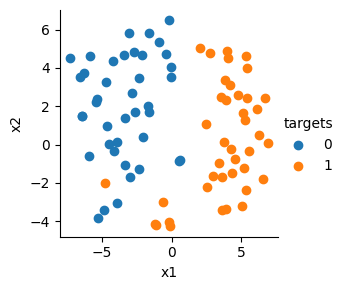

In [34]:
grid = sns.FacetGrid(df_tsne,hue = "targets")
grid.map(plt.scatter,"x1","x2").add_legend()

In [ ]:
df_tsne[["x1", "x2"]].values

In [ ]:
X.shape

Precisión del modelo: 93.75%


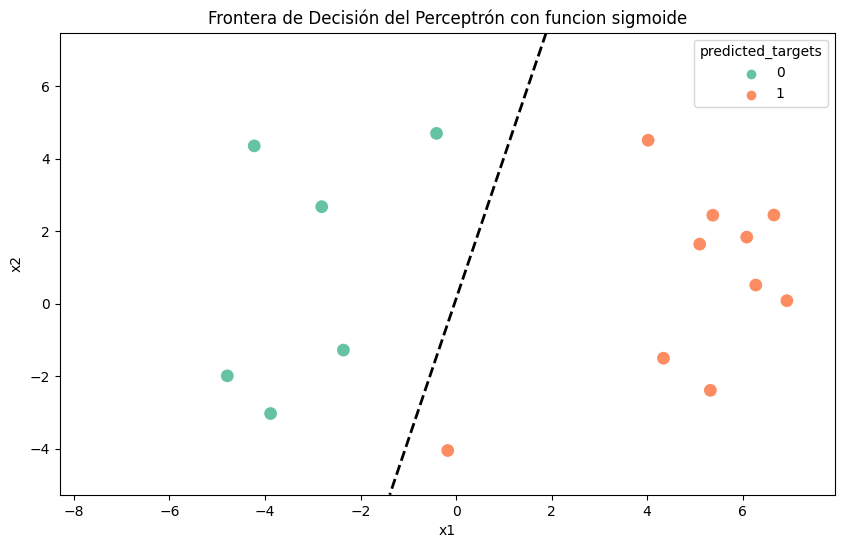

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class PerceptronSigmoide:
    """
        docs
    """
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    ### Faltó implementar la regla de actualización: esta dentro de train
    def backwards(self):
        pass
    ### Faltó implementar la evaluación (?)
    def evaluate(self):
        pass
    
    def train(self, X, y):
        """
            docs
        """
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        ### ¿Por qué no generar el contador en este loop? #############################################
        for _ in range(self.epochs):
            for xi, target in zip(X, y):
                prediction = self.predict(xi)
                update = self.learning_rate * (target - prediction)              #actualizamos los pesos y los sesgos
                self.weights += update * xi
                self.bias += update

    def sigmoid(self, x):
        """
            docs
        """
        return 1 / (1 + np.exp(-x))

    def predict(self, X):
        """
            docs
        """
        return self.sigmoid(np.dot(X, self.weights) + self.bias)            ### por què sigmoide?

# Crear una instancia del Perceptron
perceptron_1 = PerceptronSigmoide(learning_rate=0.1, epochs=1000)

# Asignar los vectores 2D y las etiquetas al conjunto de datos
X = transformed_data
y = df_tsne['targets'].values

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el perceptrón
perceptron_1.train(X_train, y_train)                                             #entregamos el conjunto de entrenamiento al metodo train de la clase

# Hacer predicciones en el conjunto de prueba
predictions = np.array([1 if perceptron_1.predict(xi) > 0.5 else 0 for xi in X_test])  ### OBS: La regla de predict debe formar parte de la clase!

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Visualizar las predicciones en el espacio 2D
df_test = pd.DataFrame(X_test, columns=['x1', 'x2'])
df_test['predicted_targets'] = predictions

# Graficar los resultados y la frontera de decisión con la función sigmoide
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test, x='x1', y='x2', hue='predicted_targets', palette='Set2', s=100)

# Visualizar la frontera de decisión (usando la función sigmoide)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Crear una malla de puntos
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
X_mesh = np.c_[xx.ravel(), yy.ravel()]

# Calcular las probabilidades en la malla usando la función sigmoide
Z = perceptron_1.sigmoid(np.dot(X_mesh, perceptron_1.weights) + perceptron_1.bias)
Z = Z.reshape(xx.shape)

# Graficar la frontera de decisión
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)

plt.title("Frontera de Decisión del Perceptrón con funcion sigmoide")
plt.show()


Precisión del perceptrón: 93.75%


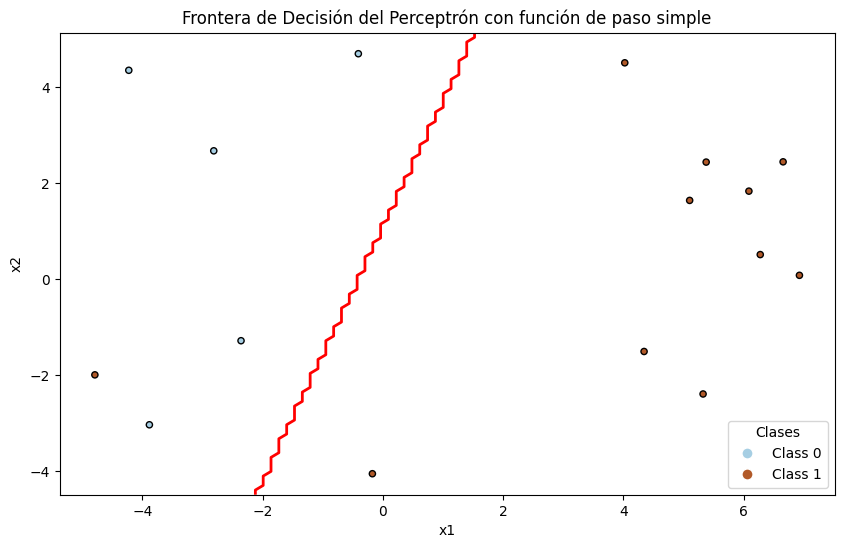

In [64]:
 class PerceptronStep1:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def _initialize_weights(self, num_features):
        # Inicializa los pesos y sesgo con ceros al principio
        self.weights = np.zeros(num_features)
        self.bias = 0

    ### esto está mejor #####################################
    def _step_function(self, x):
        # Función de paso simple: devuelve 1 si x es mayor o igual a cero, 0 de lo contrario
        return 1 if x >= 0 else 0

    def _predict(self, X):
        # Predice la clase para cada entrada en X usando la función de paso
        return np.array([self._step_function(np.dot(self.weights, x) + self.bias) for x in X])  ### explicar esto!

    def fit(self, X, y):
        num_features = X.shape[1]
        self._initialize_weights(num_features)

        # Ciclo de entrenamiento (épocas)
        for epoch in range(self.epochs):
            # Ciclo a través de cada entrada de entrenamiento
            for xi, yi in zip(X, y):                                ### para qué sirve zip()
                # Realiza la predicción usando la función de paso
                prediction = self._step_function(np.dot(xi, self.weights) + self.bias)

                #### esto deberia ser parte del backwards
                # Actualiza los pesos y el sesgo basado en el error
                self.weights += self.learning_rate * (yi - prediction) * xi
                self.bias += self.learning_rate * (yi - prediction)

    def predict(self, X):
        # Predice la clase para cada entrada en X usando la función de paso
        return self._predict(X)

# Crear etiquetas para los datos (1 para kick, 0 para snare)
labels = np.concatenate([np.ones(40), np.zeros(40)])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(transformed_data, labels, test_size=0.2, random_state=42)

# Inicializar el perceptrón
perceptron_2 =  PerceptronStep1()

# Entrenar el perceptrón
perceptron_2.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = perceptron_2.predict(X_test)

# Calcular la precisión del perceptrón
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del perceptrón: {accuracy * 100:.2f}%")

# Visualizar la frontera de decisión del perceptrón
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.title('Frontera de Decisión del Perceptrón con función de paso simple')
plt.xlabel('x1')
plt.ylabel('x2')

# Crear la línea de decisión
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear una cuadrícula para evaluar el modelo
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = perceptron_2._predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualizar la línea de decisión y los márgenes
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
ax.contour(xx, yy, Z + 1, levels=[0], linewidths=1, linestyles='dashed', colors='gray')
ax.contour(xx, yy, Z - 1, levels=[0], linewidths=1, linestyles='dashed', colors='gray')

# Agregar leyenda para la Frontera de Decisión
ax.legend(['Decision Boundary'], loc='upper right')

# Agregar leyendas para las clases
legend_labels = ['Class 0', 'Class 1']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
           for label, color in zip(legend_labels, scatter.get_cmap()(np.unique(y_test)))]  # Colores de ambas clases
ax.legend(handles=handles, title='Clases', loc='lower right')

plt.show()


Precisión del modelo: 81.25%


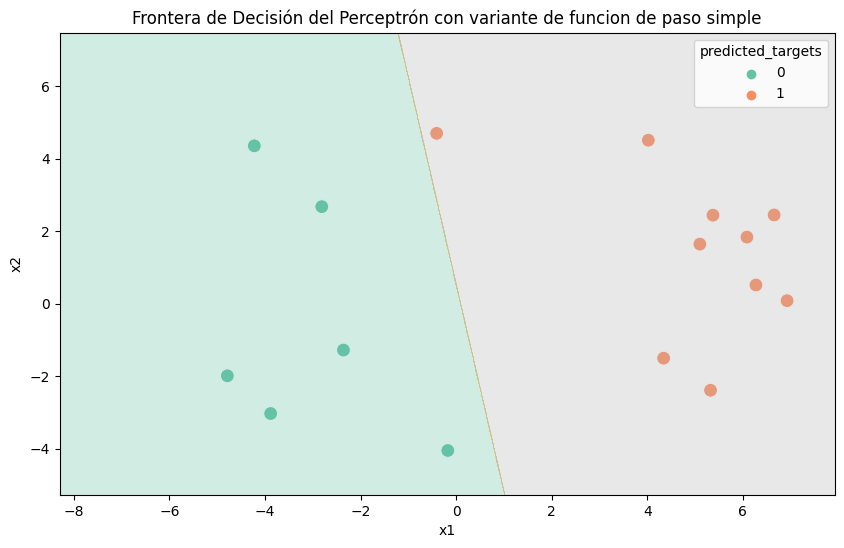

Pesos sinápticos: [1.0610684  0.18580872]
Sesgo: -0.09999999999999998


In [65]:
class PerceptronStep2:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, X, y):
      #inicializamos los pesos y el sesgo
        self.weights = np.zeros(2)
        self.bias = 0

        for _ in range(self.epochs):
            for xi, target in zip(X, y):
                prediction = self.predict(xi)
                update = self.learning_rate * (target - prediction)
                self.weights += update * xi
                self.bias += update

    def predict(self, X):
        return 1 if (np.dot(X, self.weights) + self.bias) > 0 else 0

# Crear una instancia del Perceptron
perceptron_3 = PerceptronStep2(learning_rate=0.1, epochs=1000)

# Asignar los vectores 2D y las etiquetas al conjunto de datos
X = transformed_data
y = df_tsne['targets'].values

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el perceptrón
perceptron_3.train(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions = np.array([perceptron_3.predict(xi) for xi in X_test])

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Visualizar las predicciones en el espacio 2D
df_test = pd.DataFrame(X_test, columns=['x1', 'x2'])
df_test['predicted_targets'] = predictions
df_test['predicted_targets'] = df_test['predicted_targets'].astype('category')

# Graficar los resultados y la frontera de decisión
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df_test, x='x1', y='x2', hue='predicted_targets', palette='Set2', s=100)

# Visualizar la frontera de decisión
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = np.array([perceptron.predict(xi) for xi in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set2')

plt.title("Frontera de Decisión del Perceptrón con variante de funcion de paso simple")
plt.show()

# Mostrar pesos sinápticos y sesgo
print(f"Pesos sinápticos: {perceptron.weights}")
print(f"Sesgo: {perceptron.bias}")
